## Алгоритмы машинного обучения. Деревья решений. Случайный лес

In [1]:
# импорт библиотек

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# версия библиотеки sklearn

print(sklearn.__version__)

0.21.3


In [3]:
# читаем датасет

data = pd.read_csv('titanic_train.csv')

In [4]:
data.head()

,pclass,sex,age,sibsp,parch,fare,survived
0,3,female,NaN,0,0,7.7333,1
1,3,male,38.0,0,0,8.6625,0
2,3,female,30.0,1,1,24.1500,0
3,2,female,54.0,1,3,23.0000,1
4,2,male,40.0,0,0,13.0000,0


In [5]:
# небольшой препроцессинг

data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data['age'] = np.trunc(data['age'])
data = data.fillna(data.median())

In [6]:
data.head()

,pclass,sex,age,sibsp,parch,fare,survived
0,3,1,28.0,0,0,7.7333,1
1,3,0,38.0,0,0,8.6625,0
2,3,1,30.0,1,1,24.1500,0
3,2,1,54.0,1,3,23.0000,1
4,2,0,40.0,0,0,13.0000,0


## Функционал качества

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из функционала качества:
$$Q(X, j, t) = H(X) - \dfrac{|X_l|}{|X|} H(X_l) - \dfrac{|X_r|}{|X|} H(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $H(X)$ – критерий информативности (например, энтропия ответов на выборке $X$):
$$H(X) = - \sum_{k=0}^{N}(p_k ln p_k),$$
где $k$ – номер класса, $p_k$ – доля объектов класса $k$ в выборке $X$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

In [7]:
# реализуем функцию для расчета функционала качества

def Q(X, j, t):
    Xl = X[X[j] <= t]
    Xr = X[X[j] > t]
    quality = H(X) - len(Xl)/len(X)*H(Xl) - len(Xr)/len(X)*H(Xr)
    return quality

# реализуем функцию для расчета энтропии ответов

def H(X):
    p1 = len(X[X['survived'] == 0]) / len(X)
    p2 = len(X[X['survived'] == 1]) / len(X)
    ent = - (p1*np.log(p1) + p2*np.log(p2))
    return ent

Осуществим разбиение выборки по признаку "пол" и посмотрим на значение энтропийного критерия 

In [8]:
Q(data, 'sex', 0.6)

0.13154763017729795

Посмотрим на распределение целевой переменной в родительском и дочерних узлах.

Entropy = 0.6580097902016231
Entropy_male = 0.481744874652795
Entropy_female = 0.6088675922641685
Q = 0.13154763017729795


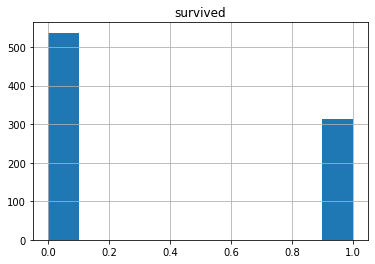

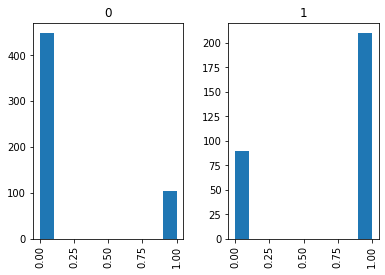

In [9]:
print('Entropy =', H(data))
data.hist(column = 'survived');
print('Entropy_male =', H(data[data['sex'] == 0]))
print('Entropy_female =', H(data[data['sex'] == 1]))
print('Q =', Q(data, 'sex', 0.5))
data.hist(column = 'survived', by = 'sex');

Видно, что при таком разбиении мы получаем 2 выборки с меньшей неопределенностью, чем исходная.

## Деревья решений в библиотеке Sklearn

Разобьем выборку на обучающую и тестовую с помощью метода `sklearn.model_selection.train_test_split`. В случае дисбаланса классов крайне рекомендуется использовать параметр `stratify`. Так мы гарантируем, что доля выживших будет одинакова в двух выборках.

In [10]:
X = data.drop('survived', axis = 1)
y = data['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=20)

Убедимся в равенстве долей выживших в обоих выборках.

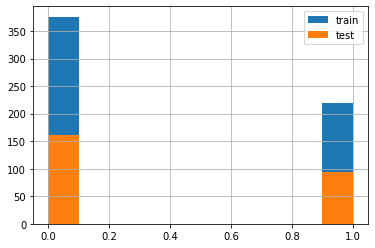

In [11]:
y_train.hist(label = 'train')
y_test.hist(label = 'test')
plt.legend();

Инициализируем дерево решений, зафиксировав `random_state`.

In [12]:
tree = DecisionTreeClassifier(random_state=20)

Обучим дерево решений на обучающей выборке.

In [13]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=20, splitter='best')

Оценим качество модели на тестовой выборке.

In [14]:
preds_test = tree.predict(X_test)
print(roc_auc_score(y_test, preds_test))

0.7481498612395929


## Кросс-валидация

Для повышения качества прогноза модели подберем значения параметра `max_depth` по кросс-валидации. Для этого будем использовать функцию `cross_val_score`.
Для справки: картинка, объясняющая суть кросс-валидации.

In [15]:
%%html
<img src="cv.png",width=60,height=60>

В случае применения кросс-валидации мы также хотим иметь одинаковую долю выживших в каждом фолде. Для этого необходимо инициализировать такую стратегию кросс-валидации, используя `StratifiedKFold`

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

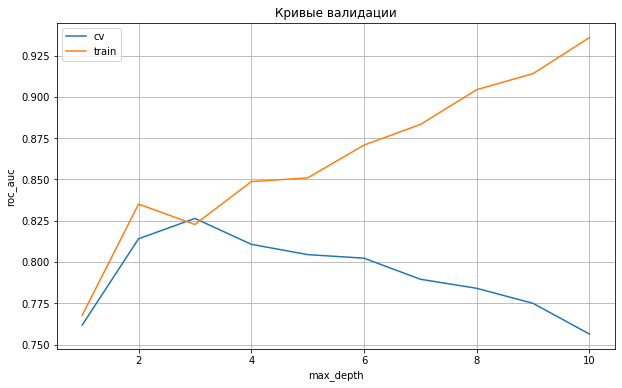

In [17]:
train_scores = []
cv_scores = []
max_depth_values = np.arange(1, 11)
for max_depth in max_depth_values:
    model = DecisionTreeClassifier(max_depth = max_depth, random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = roc_auc_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, label = 'cv')
plt.plot(max_depth_values, train_scores, label = 'train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

Обучим модель с наиболее оптимальным значением максимальной глубины на обучающей выборке.

In [18]:
best_tree = DecisionTreeClassifier(max_depth = 3, random_state=20)
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=20, splitter='best')

Сделаем прогноз на тестовой выборке с помощью лучшей модели и оценим ее качество

In [19]:
preds_test = best_tree.predict(X_test)
print(roc_auc_score(y_test, preds_test))

0.7924871151050613


Визуализируем построенное дерево

In [24]:
#pip install graphviz
#sudo apt install python-pydot python-pydot-ng graphviz 

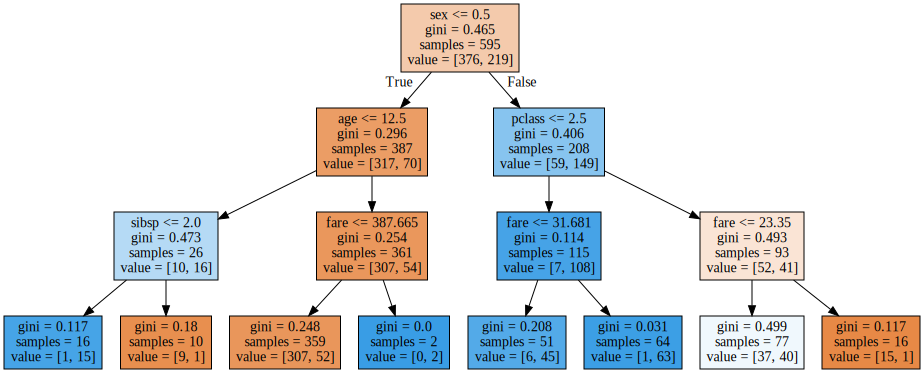

In [26]:
from sklearn.tree import export_graphviz
import graphviz
tree_str = export_graphviz(best_tree, feature_names=X_train.columns, filled=True)
graphviz.Source(tree_str)

## Случайный лес в библиотеке Sklearn

Инициализируем случайный лес, зафиксировав `random_state`.

In [30]:
rf = RandomForestClassifier(random_state = 20)

Обучим случайный лес на обучающей выборке.

In [31]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

Оценим качество модели на тестовой выборке.

In [32]:
preds_test = rf.predict(X_test)
print(roc_auc_score(y_test, preds_test))

0.7911655874190564


Посмотрим, как меняется качество на кросс-валидации в зависимости от количества деревьев в случайном лесе.

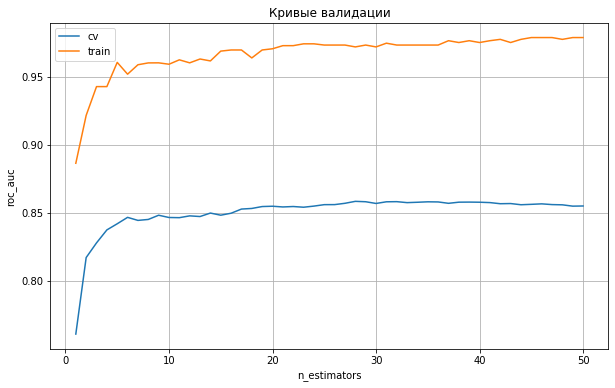

In [33]:
train_scores = []
cv_scores = []
n_estimators_values = np.arange(1, 51)
for n_estimators in n_estimators_values:
    model = RandomForestClassifier(n_estimators = n_estimators, random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = roc_auc_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, cv_scores, label='cv')
plt.plot(n_estimators_values, train_scores, label='train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

Теперь посмотрим, как меняется качество на кросс-валидации в зависимости от максимальной глубины в случайном лесе.

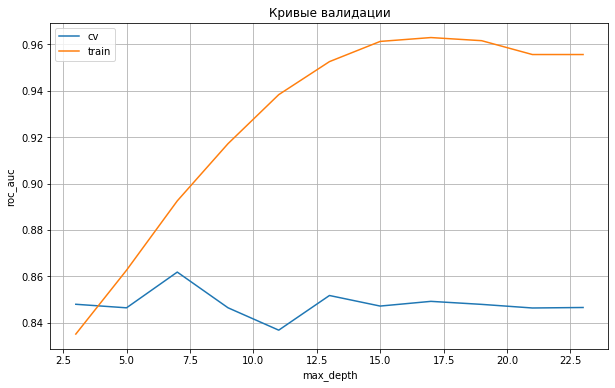

In [69]:
train_scores = []
cv_scores = []
max_depth_values = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
for max_depth in max_depth_values:
    model = RandomForestClassifier(max_depth = max_depth, random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = roc_auc_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, label='cv')
plt.plot(max_depth_values, train_scores, label='train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

Наконец, посмотрим, как меняется качество на кросс-валидации в зависимости от минимального числа объектов в листе в случайном лесе.

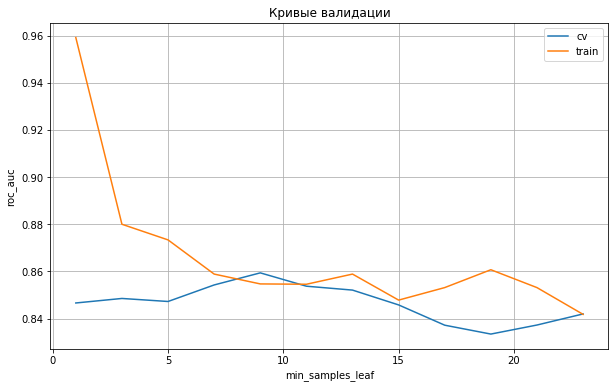

In [70]:
train_scores = []
cv_scores = []
min_samples_leaf_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
for min_samples_leaf in min_samples_leaf_values:
    model = RandomForestClassifier(min_samples_leaf = min_samples_leaf, random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'roc_auc').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = roc_auc_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, cv_scores, label='cv')
plt.plot(min_samples_leaf_values, train_scores, label='train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('min_samples_leaf')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

## GridSearchCV

Ранее мы в цикле по разным значениям гиперпараметров оценивали качество модели на кросс-валидации. С помощью инструмента `GridSearchCV` библиотеки Sklearn это можно сделать гораздо быстрее.

Создадим словарь param_grid, который будет хранить в себе значения гиперпараметров, по которым будет проводиться подбор оптимальных значений.

In [34]:
param_grid = {'min_samples_leaf': [1,3,5,7,8,9,10,15], 'max_depth': [2,3,4,5,6,7,8,9,None]}

In [35]:
rf = RandomForestClassifier(random_state = 20)
grid = GridSearchCV(estimator=rf, param_grid=param_grid, scoring = 'roc_auc', cv = cv)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=20,
                                              verbose=0, warm_start=Fa

Выведем лучшие гипермараметры на кросс-валидации.

In [36]:
print(grid.best_params_)

{'max_depth': 7, 'min_samples_leaf': 1}


Сохраним модель с лучшими параметрами на кросс-валидации.

In [37]:
best_rf = grid.best_estimator_

Оценим качество данной модели на тестовой выборке.

In [39]:
preds_test = best_rf.predict(X_test)
print(roc_auc_score(y_test, preds_test))

0.7747786441125942


## Оценка важности признаков случайного леса

В отличие от деревьев решений, случайный лес невозможно визуализировать. Однако оценить важность признаков можно с помощью метода feature_importances_.

In [41]:
importances = best_rf.feature_importances_
importances

array([0.11958949, 0.3993291 , 0.17083197, 0.05844095, 0.05099619,
       0.2008123 ])

Визуализируем важности признаков с помощью гистограммы.

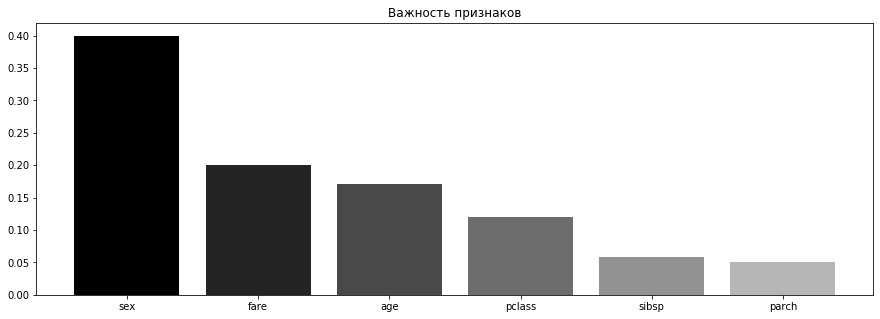

In [42]:
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15,5))
plt.title("Важность признаков")
bars = plt.bar(X_train.columns[indices], 
               importances[indices],
       color=([str(i/float(len(indices)+1)) 
               for i in range(len(indices))]),
               align="center")